# BMCS2003 Artificial Intelligence

| Name | Student ID |
| --- | --- |
| Ivan Yeoh Zi Jie | 23WMR14699 |
| Yap Jia Qi | 23WMR15554 |
| Koh Wei Sheng | 23WMR15301 |



# Load Dataset

In [10]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Display settings
pd.options.mode.copy_on_write = True
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load Excel dataset
df = pd.read_excel(r"C:\Users\IvanYeoh\Online Retail.xlsx")

# Quick check
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())


Dataset shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----     

# Drop unwanted data, encode data, inspect datatypes & missing values

In [3]:
# 1. Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# 2. Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 3. Remove rows with non-positive Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 4. Drop duplicates if any
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before - after} duplicate rows")

# 5. Encode CustomerID as integer
df['CustomerID'] = df['CustomerID'].astype(int)

# 6. Inspect datatypes
print("\nData types info:")
print(df.info())

# 7. Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Removed 150457 duplicate rows

Data types info:
<class 'pandas.core.frame.DataFrame'>
Index: 247427 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    247427 non-null  object        
 1   Quantity     247427 non-null  int64         
 2   InvoiceDate  247427 non-null  datetime64[ns]
 3   UnitPrice    247427 non-null  float64       
 4   CustomerID   247427 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 11.3+ MB
None

Missing values per column:
InvoiceNo      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64


In [5]:
#cleaned dataset
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,6,2010-12-01 08:26:00,2.55,17850
1,536365,6,2010-12-01 08:26:00,3.39,17850
2,536365,8,2010-12-01 08:26:00,2.75,17850
5,536365,2,2010-12-01 08:26:00,7.65,17850
6,536365,6,2010-12-01 08:26:00,4.25,17850


# Calculate RFM(Recency, Frequency, Monetary) values for each customer

In [11]:
import pandas as pd

# Make sure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add total price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Reference date = latest date in dataset
reference_date = df['InvoiceDate'].max()

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Dataset Shape:", rfm.shape)
print(rfm.head())


RFM Dataset Shape: (4372, 4)
   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


# Data Visualization(Heatmap, Pairplot)

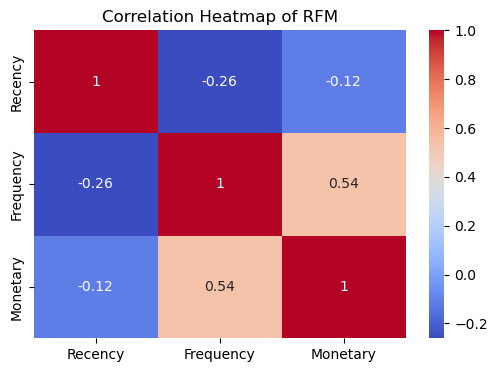

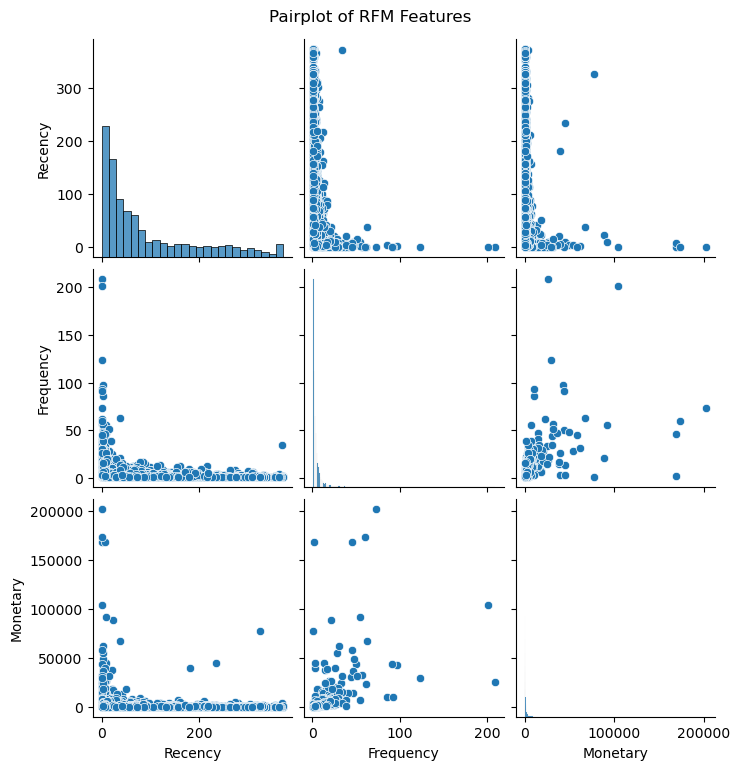

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(rfm[['Recency','Frequency','Monetary']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of RFM")
plt.show()

# Pairplot
sns.pairplot(rfm[['Recency','Frequency','Monetary']])
plt.suptitle("Pairplot of RFM Features", y=1.02)
plt.show()


# Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

# Select only RFM features
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for easier use later
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency','Frequency','Monetary'])

print(rfm_scaled.head())


    Recency  Frequency  Monetary
0  2.322023  -0.329362 -0.231001
1 -0.893733   0.206102  0.293432
2 -0.169196  -0.115176 -0.012316
3 -0.725005  -0.436455 -0.017146
4  2.163220  -0.436455 -0.190312


# K-Means Algorithm

## Elbow Method

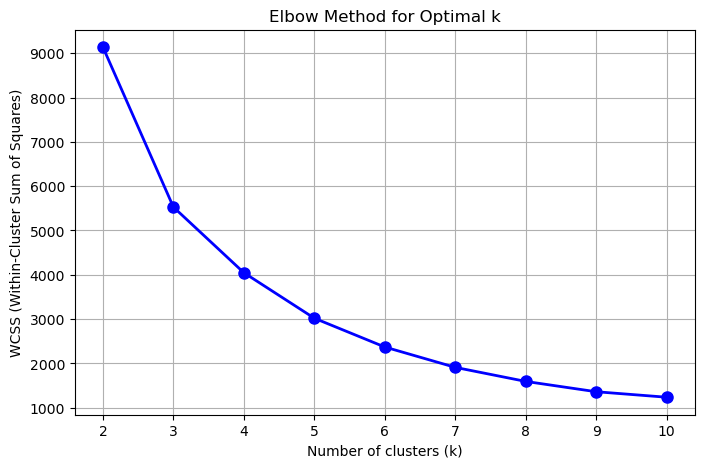

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of k values to test
K = range(2, 11)  
wcss = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)  # rfm_scaled = your scaled dataset
    wcss.append(kmeans.inertia_)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(K, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)



plt.show()


## Silhouette Score

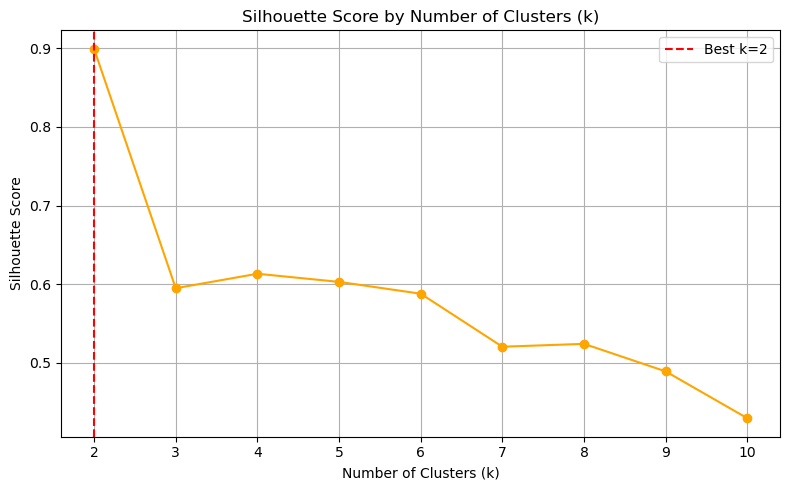

Best Silhouette result → k = 2, Silhouette = 0.8993


In [42]:

from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    score = silhouette_score(rfm_scaled[['Recency', 'Frequency', 'Monetary']], labels)
    sil_scores.append(score)

# Best k by silhouette
best_k_sil = K[sil_scores.index(max(sil_scores))]
best_sil = max(sil_scores)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K, sil_scores, marker='o', linestyle='-', color='orange')
plt.axvline(best_k_sil, color='red', linestyle='--', label=f'Best k={best_k_sil}')
plt.title("Silhouette Score by Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best Silhouette result → k = {best_k_sil}, Silhouette = {best_sil:.4f}")


## Calculate and find best Calinski Harabasz Score for Kmean

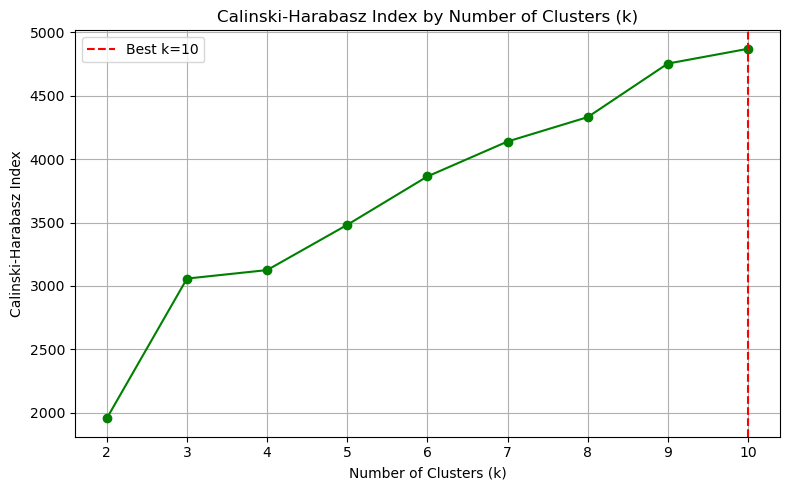

Best CHI result → k = 10, CHI = 4871.2917


In [38]:
from sklearn.metrics import calinski_harabasz_score

# Step 4: Calculate Calinski-Harabasz Index
# =========================================
ch_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    
    # Calculate CHI
    ch_score = calinski_harabasz_score(rfm_scaled[['Recency', 'Frequency', 'Monetary']], labels)
    ch_scores.append(ch_score)

# Best result
best_k_ch = k_values[ch_scores.index(max(ch_scores))]
best_ch = max(ch_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, ch_scores, marker='o', linestyle='-', color='green')
plt.axvline(best_k_ch, color='red', linestyle='--', label=f'Best k={best_k_ch}')
plt.title("Calinski-Harabasz Index by Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best result
print(f"Best CHI result → k = {best_k_ch}, CHI = {best_ch:.4f}")



## Calculate and find best Davies-Bouldin Index for Kmean

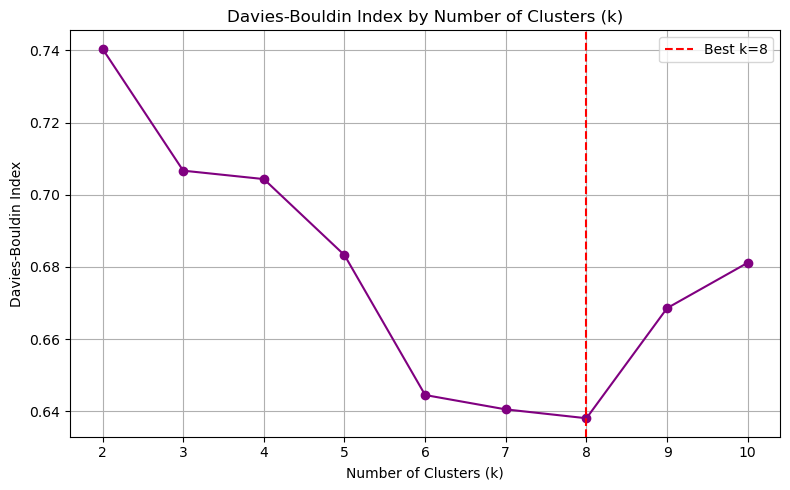

Best DBI result → k = 8, DBI = 0.6381


In [40]:
from sklearn.metrics import davies_bouldin_score

# Step 5: Calculate Davies-Bouldin Index
# ======================================
dbi_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    
    # Calculate DBI
    dbi_score = davies_bouldin_score(rfm_scaled[['Recency', 'Frequency', 'Monetary']], labels)
    dbi_scores.append(dbi_score)

# Best result (lower DBI = better)
best_k_dbi = k_values[dbi_scores.index(min(dbi_scores))]
best_dbi = min(dbi_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, dbi_scores, marker='o', linestyle='-', color='purple')
plt.axvline(best_k_dbi, color='red', linestyle='--', label=f'Best k={best_k_dbi}')
plt.title("Davies-Bouldin Index by Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best result
print(f"Best DBI result → k = {best_k_dbi}, DBI = {best_dbi:.4f}")


## Visualize Graph

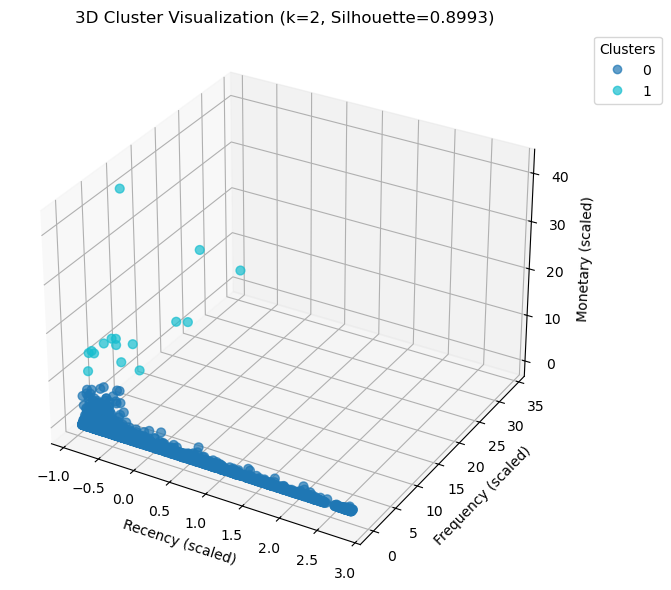

In [35]:
# --- Cell 1: 3D Cluster Visualization ---

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load RFM dataset
rfm = pd.read_csv(r"C:\Users\IvanYeoh\rfm.csv")

# Scale Recency, Frequency, Monetary
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']]),
    columns=['Recency', 'Frequency', 'Monetary']
)

# KMeans with k=2 (best Silhouette)
best_k = 2
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_best.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm_scaled['Recency'], 
    rfm_scaled['Frequency'], 
    rfm_scaled['Monetary'], 
    c=rfm['Cluster'], 
    cmap='tab10', 
    s=40, alpha=0.7
)

ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title(f"3D Cluster Visualization (k={best_k}, Silhouette=0.8993)")

plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## K-Means Summary

In [36]:
# --- Cell 2: KMeans Cluster Summary ---

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load RFM dataset
rfm = pd.read_csv(r"C:\Users\IvanYeoh\rfm.csv")

# Keep only numeric columns
features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans with k=2 (best Silhouette)
best_k = 2
kmeans_summary = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_summary.fit_predict(scaled_features)

# Cluster summary table
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

cluster_summary = cluster_summary.round(2)

# Add descriptive labels
overall_mean = rfm[['Recency', 'Frequency', 'Monetary']].mean()

def describe_cluster(row, overall_mean):
    desc = []
    # Recency
    if row['Recency'] < overall_mean['Recency'] * 0.7:
        desc.append("Recent buyers")
    elif row['Recency'] > overall_mean['Recency'] * 1.3:
        desc.append("Inactive / Churn risk")
    else:
        desc.append("Average recency")
    # Frequency
    if row['Frequency'] > overall_mean['Frequency'] * 1.3:
        desc.append("Frequent buyers")
    elif row['Frequency'] < overall_mean['Frequency'] * 0.7:
        desc.append("Rare buyers")
    else:
        desc.append("Moderate frequency")
    # Monetary
    if row['Monetary'] > overall_mean['Monetary'] * 1.3:
        desc.append("High spenders")
    elif row['Monetary'] < overall_mean['Monetary'] * 0.7:
        desc.append("Low spenders")
    else:
        desc.append("Average spenders")
    return ", ".join(desc)

cluster_summary['Description'] = cluster_summary.apply(
    lambda row: describe_cluster(row, overall_mean), axis=1
)

# Styled output
styled_summary = cluster_summary.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
).set_caption(f"📊 KMeans Cluster Summary with k={best_k}, Silhouette=0.8993")

styled_summary


,Recency,Frequency,Monetary,Count,Description
Cluster,,,,,
0,92.370000,84.340000,917.230000,4356,"Average recency, Moderate frequency, Average spenders"
1,4.500000,2464.690000,56964.880000,16,"Recent buyers, Frequent buyers, High spenders"


# Mean Shift

## Find the best bandwidth base on result of the clusters formed

In [19]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# If rfm_scaled is a NumPy array → wrap into a DataFrame
X = pd.DataFrame(rfm_scaled, columns=['Recency','Frequency','Monetary']).values

# Step 1: Estimate a starting bandwidth
est_bw = estimate_bandwidth(X, quantile=0.2, n_samples=1000, random_state=42)
print(f"Estimated bandwidth (quantile=0.2): {est_bw:.3f}")

# Step 2: Sweep a range around the estimate
candidates = np.unique(np.round(np.linspace(est_bw*0.5, est_bw*2.0, 12), 3))

best_sil, best_bw = -1, None
for bw in candidates:
    ms = MeanShift(bandwidth=bw, bin_seeding=True)
    labels = ms.fit_predict(X)
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:   # skip degenerate cases
        continue
    sil = silhouette_score(X, labels)
    print(f"Bandwidth {bw:.3f} → clusters={n_clusters}, silhouette={sil:.4f}")
    if sil > best_sil:
        best_sil, best_bw = sil, bw

print(f"\n✅ Chosen bandwidth: {best_bw:.3f} (Silhouette={best_sil:.4f})")


Estimated bandwidth (quantile=0.2): 0.783
Bandwidth 0.392 → clusters=67, silhouette=0.3921
Bandwidth 0.498 → clusters=50, silhouette=0.4350
Bandwidth 0.605 → clusters=38, silhouette=0.4895
Bandwidth 0.712 → clusters=34, silhouette=0.3780
Bandwidth 0.819 → clusters=27, silhouette=0.5742
Bandwidth 0.926 → clusters=22, silhouette=0.5136
Bandwidth 1.032 → clusters=21, silhouette=0.5977
Bandwidth 1.139 → clusters=19, silhouette=0.6018
Bandwidth 1.246 → clusters=19, silhouette=0.5973
Bandwidth 1.353 → clusters=18, silhouette=0.6161
Bandwidth 1.460 → clusters=17, silhouette=0.6592
Bandwidth 1.566 → clusters=16, silhouette=0.6593

✅ Chosen bandwidth: 1.566 (Silhouette=0.6593)


## Silhouette Score

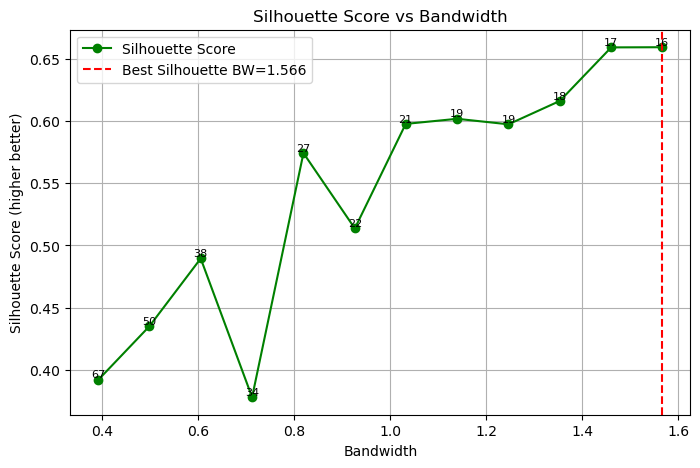


Best Silhouette Score: 0.6592986631898874 at BW= 1.566 Clusters= 16


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Prepare lists to store results
sil_scores, valid_bw_sil, n_clusters_sil = [], [], []

# Use the same candidate bandwidths as before
bandwidth_values = candidates  # candidates from your estimate_bandwidth sweep

for bw in bandwidth_values:
    ms = MeanShift(bandwidth=bw, bin_seeding=True)
    ms.fit(X)  # X = rfm_scaled.values
    labels = ms.labels_
    n_clusters = len(np.unique(labels))
    
    if n_clusters > 1:  # skip degenerate cases
        sil = silhouette_score(X, labels)
        sil_scores.append(sil)
        valid_bw_sil.append(bw)
        n_clusters_sil.append(n_clusters)

# Plot Silhouette vs Bandwidth
plt.figure(figsize=(8,5))
plt.plot(valid_bw_sil, sil_scores, marker='o', color='green', label="Silhouette Score")
for bw, score, ncl in zip(valid_bw_sil, sil_scores, n_clusters_sil):
    plt.text(bw, score, str(ncl), fontsize=8, ha='center', va='bottom')

best_sil_idx = np.argmax(sil_scores)
plt.axvline(valid_bw_sil[best_sil_idx], color='red', linestyle='--',
            label=f"Best Silhouette BW={valid_bw_sil[best_sil_idx]:.3f}")
plt.title("Silhouette Score vs Bandwidth")
plt.xlabel("Bandwidth")
plt.ylabel("Silhouette Score (higher better)")
plt.legend()
plt.grid(True)
plt.show()

print("\nBest Silhouette Score:", sil_scores[best_sil_idx],
      "at BW=", valid_bw_sil[best_sil_idx],
      "Clusters=", n_clusters_sil[best_sil_idx])


## Calculate and find best Calinski–Harabasz score for Mean Shift

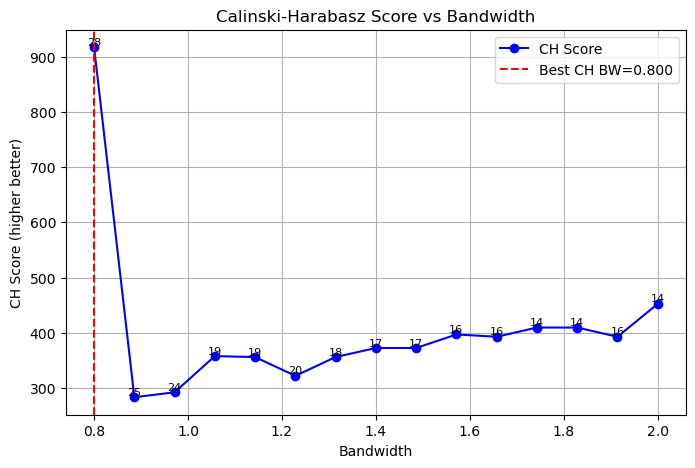


Best CH Score: 916.8222918899943 at BW= 0.8 Clusters= 28


In [19]:
ch_scores, valid_bw_ch, n_clusters_ch = [], [], []

for bw in bandwidth_values:
    ms = MeanShift(bandwidth=bw, bin_seeding=True)
    ms.fit(scaled_features)
    labels = ms.labels_
    n_clusters = len(np.unique(labels))
    if n_clusters > 1:
        ch = calinski_harabasz_score(scaled_features, labels)
        ch_scores.append(ch)
        valid_bw_ch.append(bw)
        n_clusters_ch.append(n_clusters)

plt.figure(figsize=(8,5))
plt.plot(valid_bw_ch, ch_scores, marker='o', color='blue', label="CH Score")
for bw, score, ncl in zip(valid_bw_ch, ch_scores, n_clusters_ch):
    plt.text(bw, score, str(ncl), fontsize=8, ha='center', va='bottom')

best_ch = np.argmax(ch_scores)
plt.axvline(valid_bw_ch[best_ch], color='red', linestyle='--',
            label=f"Best CH BW={valid_bw_ch[best_ch]:.3f}")
plt.title("Calinski-Harabasz Score vs Bandwidth")
plt.xlabel("Bandwidth")
plt.ylabel("CH Score (higher better)")
plt.legend()
plt.grid(True)
plt.show()

print("\nBest CH Score:", ch_scores[best_ch],
      "at BW=", valid_bw_ch[best_ch],
      "Clusters=", n_clusters_ch[best_ch])


## Calculate and find best Davies-Bouldin Index for Mean Shift

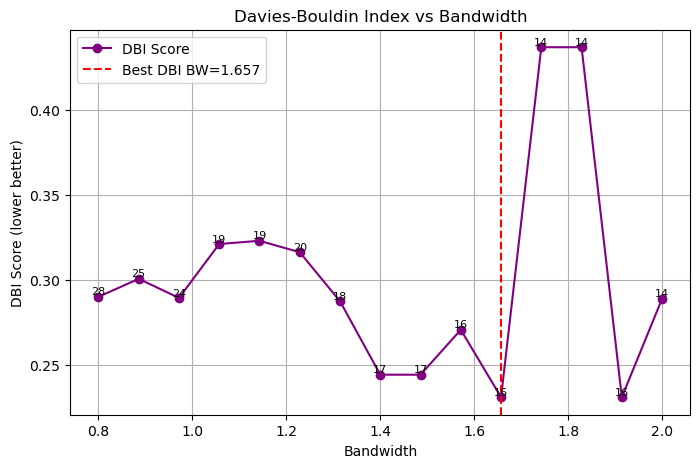


Best DBI Score: 0.23119643877384394 at BW= 1.6571428571428573 Clusters= 16


In [20]:
db_scores, valid_bw_db, n_clusters_db = [], [], []

for bw in bandwidth_values:
    ms = MeanShift(bandwidth=bw, bin_seeding=True)
    ms.fit(scaled_features)
    labels = ms.labels_
    n_clusters = len(np.unique(labels))
    if n_clusters > 1:
        dbi = davies_bouldin_score(scaled_features, labels)
        db_scores.append(dbi)
        valid_bw_db.append(bw)
        n_clusters_db.append(n_clusters)

plt.figure(figsize=(8,5))
plt.plot(valid_bw_db, db_scores, marker='o', color='purple', label="DBI Score")
for bw, score, ncl in zip(valid_bw_db, db_scores, n_clusters_db):
    plt.text(bw, score, str(ncl), fontsize=8, ha='center', va='bottom')

best_db = np.argmin(db_scores)
plt.axvline(valid_bw_db[best_db], color='red', linestyle='--',
            label=f"Best DBI BW={valid_bw_db[best_db]:.3f}")
plt.title("Davies-Bouldin Index vs Bandwidth")
plt.xlabel("Bandwidth")
plt.ylabel("DBI Score (lower better)")
plt.legend()
plt.grid(True)
plt.show()

print("\nBest DBI Score:", db_scores[best_db],
      "at BW=", valid_bw_db[best_db],
      "Clusters=", n_clusters_db[best_db])


## Visualize Graph

In [8]:
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# MeanShift with chosen bandwidth
bandwidth = 1.566
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_labels = ms.fit_predict(rfm_scaled)

# Add cluster labels
rfm_ms = rfm.copy()
rfm_ms['MS_Cluster'] = ms_labels


Clusters formed: 16


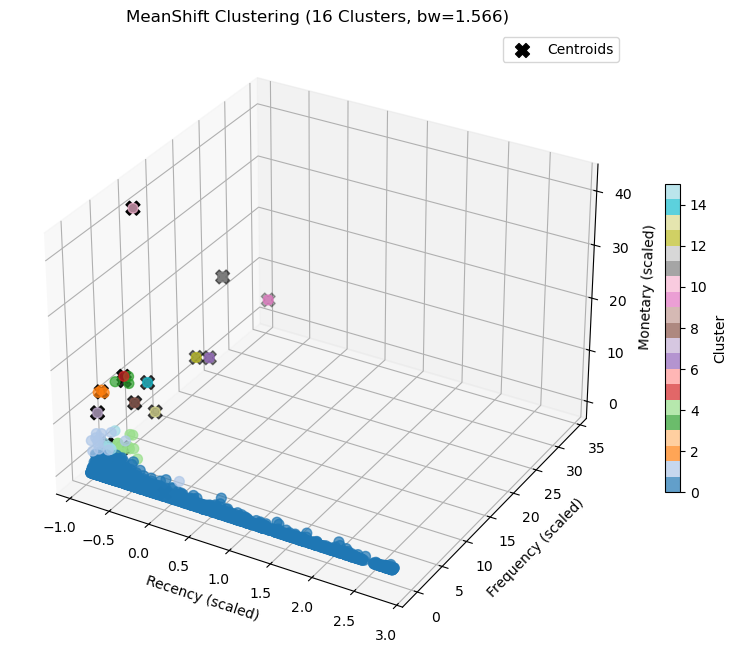

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift
import numpy as np

# === MeanShift with Silhouette's best bandwidth (16 clusters) ===
best_bw = 1.566
ms = MeanShift(bandwidth=best_bw, bin_seeding=True)
labels = ms.fit_predict(rfm_scaled)  # use the same scaled RFM features

# Assign cluster labels back to RFM dataframe
rfm['Cluster'] = labels
n_clusters = len(np.unique(labels))
print(f"Clusters formed: {n_clusters}")

# --- 3D Scatter Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm_scaled[:, 0], 
    rfm_scaled[:, 1], 
    rfm_scaled[:, 2],
    c=labels, cmap='tab20', s=50, alpha=0.7
)

ax.set_xlabel("Recency (scaled)")
ax.set_ylabel("Frequency (scaled)")
ax.set_zlabel("Monetary (scaled)")
ax.set_title(f"MeanShift Clustering (16 Clusters, bw={best_bw})")

# Optional: Add cluster centroids
centroids = np.array([rfm_scaled[labels==i].mean(axis=0) for i in range(n_clusters)])
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
           c='black', s=100, marker='X', label='Centroids')

plt.colorbar(scatter, ax=ax, shrink=0.5, label='Cluster')
plt.legend()
plt.show()


In [ ]:
#  X=Recency           Y=Frequency            Z=Monetary

## MeanShift Summary

In [36]:
# === Cluster Summary Table ===
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

cluster_summary = cluster_summary.round(2)

# --- Add Descriptions ---
overall_mean = rfm[['Recency', 'Frequency', 'Monetary']].mean()

def describe_cluster(row, overall_mean):
    desc = []
    # Recency (lower = better)
    if row['Recency'] < overall_mean['Recency'] * 0.7:
        desc.append("Recent buyers")
    elif row['Recency'] > overall_mean['Recency'] * 1.3:
        desc.append("Inactive / Churn risk")
    else:
        desc.append("Average recency")

    # Frequency
    if row['Frequency'] > overall_mean['Frequency'] * 1.3:
        desc.append("Frequent buyers")
    elif row['Frequency'] < overall_mean['Frequency'] * 0.7:
        desc.append("Rare buyers")
    else:
        desc.append("Moderate frequency")

    # Monetary
    if row['Monetary'] > overall_mean['Monetary'] * 1.3:
        desc.append("High spenders")
    elif row['Monetary'] < overall_mean['Monetary'] * 0.7:
        desc.append("Low spenders")
    else:
        desc.append("Average spenders")

    return ", ".join(desc)

cluster_summary['Description'] = cluster_summary.apply(
    lambda row: describe_cluster(row, overall_mean), axis=1
)

# --- Styled Display ---
styled_summary = cluster_summary.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
).set_caption("📊 Cluster Summary (16 Clusters, Mean RFM Values & Description)")

styled_summary


,Recency,Frequency,Monetary,Count,Description
Cluster,,,,,
0,93.090000,78.910000,804.110000,4318,"Average recency, Moderate frequency, Average spenders"
1,18.310000,185.620000,26375.920000,13,"Recent buyers, Frequent buyers, High spenders"
2,4.330000,456.330000,64984.670000,3,"Recent buyers, Frequent buyers, High spenders"
3,6.500000,1530.000000,57523.000000,2,"Recent buyers, Frequent buyers, High spenders"
4,24.000000,778.000000,77242.000000,1,"Recent buyers, Frequent buyers, High spenders"
5,4.000000,5128.000000,16335.000000,1,"Recent buyers, Frequent buyers, High spenders"
6,4.000000,281.000000,49390.000000,1,"Recent buyers, Frequent buyers, High spenders"
7,3.000000,1857.000000,30787.000000,1,"Recent buyers, Frequent buyers, High spenders"
8,3.000000,1076.000000,63012.000000,1,"Recent buyers, Frequent buyers, High spenders"


# DBSCAN

## K-Distance Graph

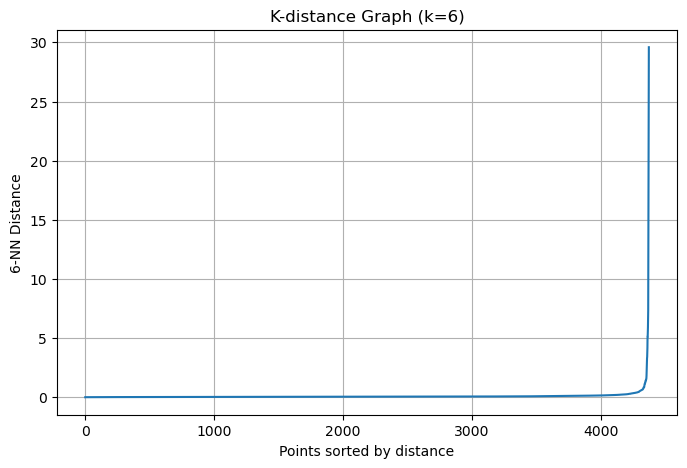

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# === Use scaled RFM features ===
X = scaled_features   # from your StandardScaler earlier

# Choose k (MinPts rule of thumb: dimensions*2 → here 3*2=6)
k = 6  

# Fit NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Take the k-th nearest distances
k_distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.ylabel(f"{k}-NN Distance")
plt.xlabel("Points sorted by distance")
plt.title(f"K-distance Graph (k={k})")
plt.grid(True)
plt.show()


## EPS scan

In [40]:
from sklearn.cluster import DBSCAN
import numpy as np

# === Try different eps values ===
eps_values = [0.5, 0.6, 0.8, 1.0, 1.2]
min_samples = 6

results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(scaled_features)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    results.append((eps, n_clusters, n_noise))

# Display results in a nice table
import pandas as pd
results_df = pd.DataFrame(results, columns=["eps", "Clusters", "Noise Points"])
results_df


,eps,Clusters,Noise Points
0,0.5,2,53
1,0.6,2,41
2,0.8,1,36
3,1.0,2,26
4,1.2,2,21


## Silhouette Score

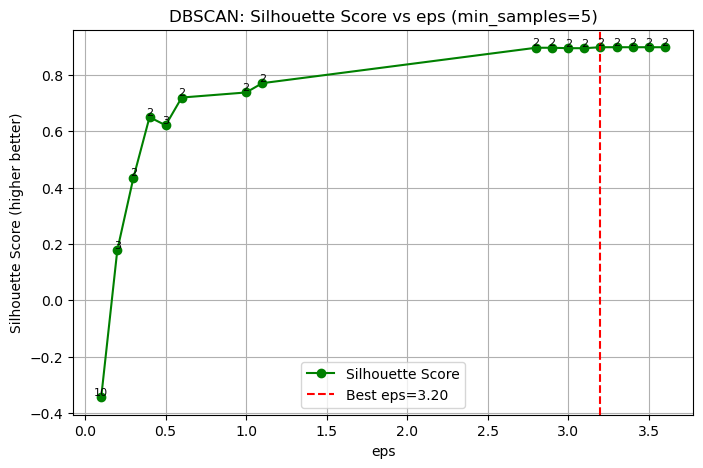


Best Silhouette Score: 0.8986 at eps=3.20, Clusters=2


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# --- Parameters to test ---
eps_values = np.linspace(0.1, 5, 50)  # Adjust range for your dataset
min_samples = 5  # Typical default; you can also test multiple values

sil_scores = []
valid_eps = []
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(rfm_scaled)  # Use scaled RFM features

    # Number of clusters (ignore noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Only compute silhouette if at least 2 clusters
    if n_clusters > 1:
        sil = silhouette_score(rfm_scaled, labels)
        sil_scores.append(sil)
        valid_eps.append(eps)
        n_clusters_list.append(n_clusters)

# --- Plot Silhouette vs eps ---
plt.figure(figsize=(8,5))
plt.plot(valid_eps, sil_scores, marker='o', color='green', label='Silhouette Score')
for eps, score, ncl in zip(valid_eps, sil_scores, n_clusters_list):
    plt.text(eps, score, str(ncl), fontsize=8, ha='center', va='bottom')

best_idx = np.argmax(sil_scores)
plt.axvline(valid_eps[best_idx], color='red', linestyle='--', 
            label=f'Best eps={valid_eps[best_idx]:.2f}')
plt.title(f'DBSCAN: Silhouette Score vs eps (min_samples={min_samples})')
plt.xlabel('eps')
plt.ylabel('Silhouette Score (higher better)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest Silhouette Score: {sil_scores[best_idx]:.4f} "
      f"at eps={valid_eps[best_idx]:.2f}, Clusters={n_clusters_list[best_idx]}")


## Calculate and find best Calinski Harabasz Score for DBSCAN

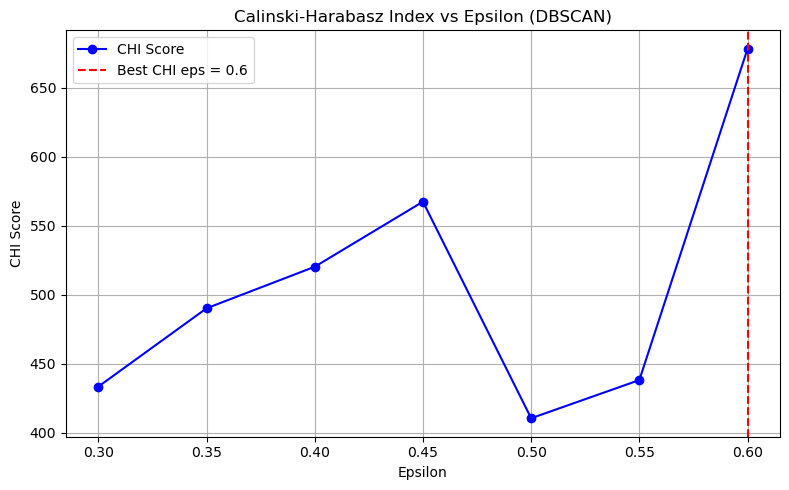

Best CHI → eps = 0.6, CHI = 678.2332


In [46]:
from sklearn.metrics import calinski_harabasz_score

eps_values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
chi_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(scaled_features)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        chi = calinski_harabasz_score(scaled_features, labels)
        chi_scores.append(chi)
    else:
        chi_scores.append(None)

# Plot CHI
plt.figure(figsize=(8, 5))
valid_chi = [score if score is not None else 0 for score in chi_scores]
plt.plot(eps_values, valid_chi, marker='o', color='blue', label="CHI Score")

if any(score is not None for score in chi_scores):
    best_idx = np.argmax([s if s is not None else -1 for s in chi_scores])
    best_eps = eps_values[best_idx]
    best_chi = chi_scores[best_idx]
    plt.axvline(best_eps, linestyle='--', color='red', label=f'Best CHI eps = {best_eps}')
    plt.title("Calinski-Harabasz Index vs Epsilon (DBSCAN)")
else:
    best_eps, best_chi = None, None
    plt.title("CHI vs Epsilon (No valid CHI scores)")

plt.xlabel("Epsilon")
plt.ylabel("CHI Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Best
if best_eps:
    print(f"Best CHI → eps = {best_eps}, CHI = {best_chi:.4f}")


## Calculate and find best Davies-Bouldin Index for DBSCAN

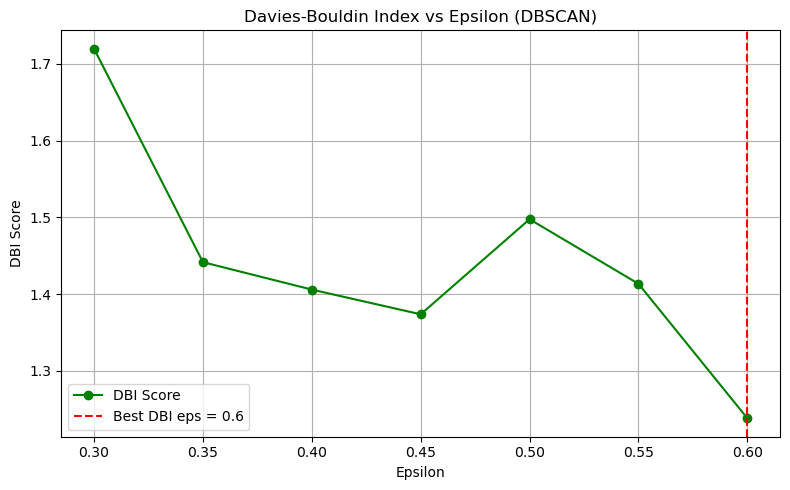

Best DBI → eps = 0.6, DBI = 1.2384


In [48]:
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

eps_values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
dbi_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(scaled_features)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        dbi = davies_bouldin_score(scaled_features, labels)
        dbi_scores.append(dbi)
    else:
        dbi_scores.append(None)

# Plot DBI
plt.figure(figsize=(8, 5))
valid_dbi = [score if score is not None else 0 for score in dbi_scores]
plt.plot(eps_values, valid_dbi, marker='o', color='green', label="DBI Score")

if any(score is not None for score in dbi_scores):
    best_idx = np.argmin([s if s is not None else float('inf') for s in dbi_scores])
    best_eps = eps_values[best_idx]
    best_dbi = dbi_scores[best_idx]
    plt.axvline(best_eps, linestyle='--', color='red', label=f'Best DBI eps = {best_eps}')
    plt.title("Davies-Bouldin Index vs Epsilon (DBSCAN)")
else:
    best_eps, best_dbi = None, None
    plt.title("DBI vs Epsilon (No valid DBI scores)")

plt.xlabel("Epsilon")
plt.ylabel("DBI Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Best
if best_eps:
    print(f"Best DBI → eps = {best_eps}, DBI = {best_dbi:.4f}")


## Visualize Graph

Clusters formed (excluding noise): 2
Noise points: 8


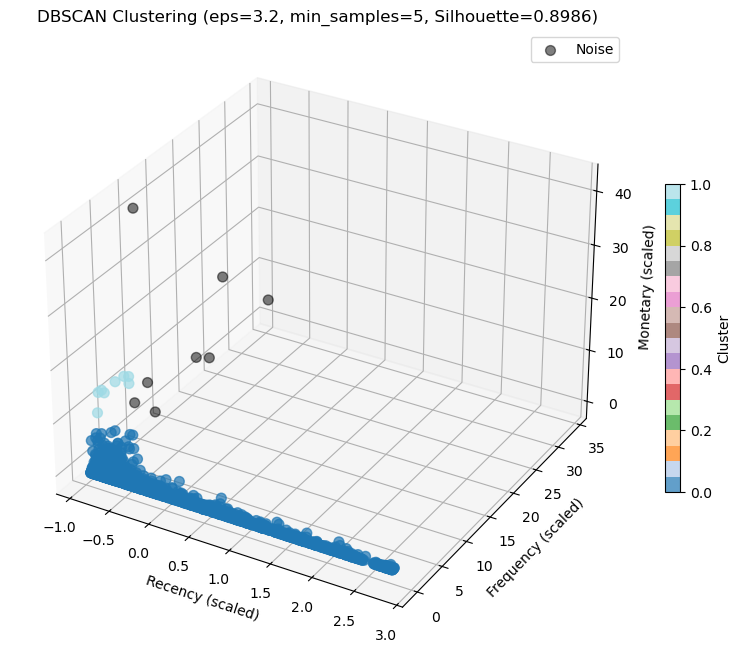

In [38]:
# --- Cell 1: DBSCAN 3D Visualization ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Assume rfm_scaled is already available from previous scaling

# DBSCAN parameters for best Silhouette
eps = 3.20
min_samples = 5

# Fit DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(rfm_scaled)

# Assign cluster labels back to RFM dataframe
rfm['Cluster'] = db_labels
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"Clusters formed (excluding noise): {n_clusters}")
print(f"Noise points: {(db_labels == -1).sum()}")

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Separate noise from actual clusters
mask_noise = db_labels == -1
mask_clusters = db_labels != -1

# Plot clusters
scatter = ax.scatter(
    rfm_scaled[mask_clusters,0],
    rfm_scaled[mask_clusters,1],
    rfm_scaled[mask_clusters,2],
    c=db_labels[mask_clusters], cmap='tab20', s=50, alpha=0.7
)

# Plot noise points in black
ax.scatter(
    rfm_scaled[mask_noise,0],
    rfm_scaled[mask_noise,1],
    rfm_scaled[mask_noise,2],
    c='black', s=50, alpha=0.5, label='Noise'
)

ax.set_xlabel("Recency (scaled)")
ax.set_ylabel("Frequency (scaled)")
ax.set_zlabel("Monetary (scaled)")
ax.set_title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples}, Silhouette=0.8986)")

plt.colorbar(scatter, ax=ax, shrink=0.5, label='Cluster')
plt.legend()
plt.show()


## DBSCAN Summary

In [39]:
# --- Cell 2: DBSCAN Cluster Summary ---

# Aggregate cluster statistics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

cluster_summary = cluster_summary.round(2)

# Overall mean for description
overall_mean = rfm[['Recency','Frequency','Monetary']].mean()

# Function to describe clusters
def describe_cluster(row, overall_mean):
    if row.name == -1:
        return "Noise / Outliers"
    
    desc = []
    # Recency
    if row['Recency'] < overall_mean['Recency']*0.7:
        desc.append("Recent buyers")
    elif row['Recency'] > overall_mean['Recency']*1.3:
        desc.append("Inactive / Churn risk")
    else:
        desc.append("Average recency")
    
    # Frequency
    if row['Frequency'] > overall_mean['Frequency']*1.3:
        desc.append("Frequent buyers")
    elif row['Frequency'] < overall_mean['Frequency']*0.7:
        desc.append("Rare buyers")
    else:
        desc.append("Moderate frequency")
    
    # Monetary
    if row['Monetary'] > overall_mean['Monetary']*1.3:
        desc.append("High spenders")
    elif row['Monetary'] < overall_mean['Monetary']*0.7:
        desc.append("Low spenders")
    else:
        desc.append("Average spenders")
    
    return ", ".join(desc)

cluster_summary['Description'] = cluster_summary.apply(lambda row: describe_cluster(row, overall_mean), axis=1)

# Styled display
styled_summary = cluster_summary.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
).set_caption(f"📊 DBSCAN Cluster Summary (eps={eps}, min_samples={min_samples}, Silhouette=0.8986)")

styled_summary


,Recency,Frequency,Monetary,Count,Description
Cluster,,,,,
-1,1.880000,4108.880000,51474.250000,8,Noise / Outliers
0,92.370000,84.340000,917.230000,4356,"Average recency, Moderate frequency, Average spenders"
1,7.120000,820.500000,62455.500000,8,"Recent buyers, Frequent buyers, High spenders"


# Algorithm Comparison

In [52]:
import pandas as pd
import time
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# ==============================
# Placeholder for results
# ==============================
comparison_data = []

# Ensure rfm_scaled is a NumPy array
X = rfm_scaled.values if hasattr(rfm_scaled, "values") else rfm_scaled

# --- 1️⃣ KMeans ---
kmeans_k = 2
best_silhouette_kmeans = 0.8993  # your reported best silhouette

start_time = time.time()
kmeans = KMeans(n_clusters=kmeans_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_time = time.time() - start_time

comparison_data.append({
    'Algorithm': 'KMeans',
    'Parameter': f'k = {kmeans_k}',
    'Clusters': len(set(kmeans_labels)),
    'Silhouette': best_silhouette_kmeans,
    'CHI': calinski_harabasz_score(X, kmeans_labels),
    'DBI': davies_bouldin_score(X, kmeans_labels),
    'Noise': 0,
    'Time(s)': round(kmeans_time, 4)
})

# --- 2️⃣ MeanShift ---
mean_bw = 1.566
best_silhouette_meanshift = 0.6592986631898874

start_time = time.time()
ms = MeanShift(bandwidth=mean_bw, bin_seeding=True)
ms_labels = ms.fit_predict(X)
ms_time = time.time() - start_time

comparison_data.append({
    'Algorithm': 'MeanShift',
    'Parameter': f'Bandwidth = {mean_bw}',
    'Clusters': len(set(ms_labels)),
    'Silhouette': best_silhouette_meanshift,
    'CHI': calinski_harabasz_score(X, ms_labels),
    'DBI': davies_bouldin_score(X, ms_labels),
    'Noise': 0,
    'Time(s)': round(ms_time, 4)
})

# --- 3️⃣ DBSCAN ---
dbscan_eps = 3.2
dbscan_min_samples = 5
best_silhouette_dbscan = 0.8986

start_time = time.time()
db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
db_labels = db.fit_predict(X)
db_time = time.time() - start_time
db_noise = list(db_labels).count(-1)

n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
comparison_data.append({
    'Algorithm': 'DBSCAN',
    'Parameter': f'eps = {dbscan_eps}, min_samples = {dbscan_min_samples}',
    'Clusters': n_clusters_db,
    'Silhouette': best_silhouette_dbscan,
    'CHI': calinski_harabasz_score(X, db_labels) if n_clusters_db > 1 else 'N/A',
    'DBI': davies_bouldin_score(X, db_labels) if n_clusters_db > 1 else 'N/A',
    'Noise': db_noise,
    'Time(s)': round(db_time, 4)
})

# ==============================
# Create comparison table
# ==============================
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


,Algorithm,Parameter,Clusters,Silhouette,CHI,DBI,Noise,Time(s)
0,KMeans,k = 2,2,0.899300,1902.257879,0.759469,0,0.0390
1,MeanShift,Bandwidth = 1.566,16,0.659299,397.072689,0.270856,0,0.1841
2,DBSCAN,"eps = 3.2, min_samples = 5",2,0.898600,1261.094072,0.946129,8,0.2304


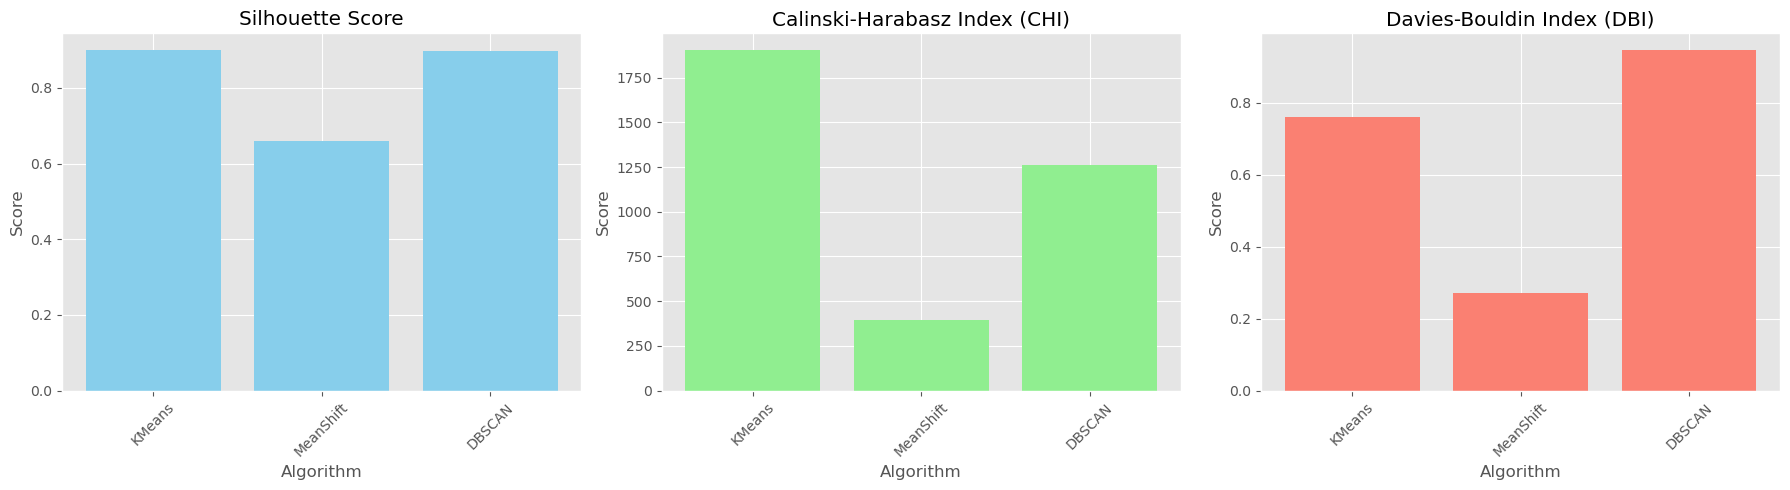

In [53]:
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('ggplot')

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Silhouette Score
axs[0].bar(comparison_df['Algorithm'], comparison_df['Silhouette'], color='skyblue')
axs[0].set_title('Silhouette Score')
axs[0].set_ylabel('Score')

# Plot CHI Score
axs[1].bar(comparison_df['Algorithm'], comparison_df['CHI'], color='lightgreen')
axs[1].set_title('Calinski-Harabasz Index (CHI)')
axs[1].set_ylabel('Score')

# Plot DBI Score (lower is better)
axs[2].bar(comparison_df['Algorithm'], comparison_df['DBI'], color='salmon')
axs[2].set_title('Davies-Bouldin Index (DBI)')
axs[2].set_ylabel('Score')

# Improve layout
for ax in axs:
    ax.set_xlabel('Algorithm')
    ax.set_xticks(range(len(comparison_df['Algorithm'])))
    ax.set_xticklabels(comparison_df['Algorithm'], rotation=45)

plt.tight_layout()
plt.show()
